In [3]:
# ========================================
# PNEUMONIA DETECTION FROM CHEST X-RAYS
# ========================================
# A Complete Deep Learning Pipeline
# Models: Baseline CNN, ResNet50, EfficientNetB0

# ========================================
# CELL 1: Setup and Imports
# ========================================

import os
import gc
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
    BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50, EfficientNetB0

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    roc_curve, auc, roc_auc_score,
    precision_score, recall_score, f1_score, accuracy_score
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Configuration
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Create directories
os.makedirs('models', exist_ok=True)

print("✅ Setup complete!")


TensorFlow version: 2.20.0
GPU Available: []
✅ Setup complete!


In [4]:
# ========================================
# CELL 2: Download Dataset
# ========================================

import kagglehub

# Download dataset
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print(f"Dataset downloaded to: {path}")

# Set data path
base_path = path
data_path = os.path.join(base_path, 'chest_xray')

print(f"✅ Data path: {data_path}")


Dataset downloaded to: /kaggle/input/chest-xray-pneumonia
✅ Data path: /kaggle/input/chest-xray-pneumonia/chest_xray


In [5]:
# ========================================
# CELL 3: Dataset Statistics
# ========================================

def count_images(directory):
    """Count images in each directory"""
    counts = {}
    for root, dirs, files in os.walk(directory):
        if 'NORMAL' in root or 'PNEUMONIA' in root:
            class_name = os.path.basename(root)
            split_name = os.path.basename(os.path.dirname(root))
            key = f"{split_name}/{class_name}"
            counts[key] = len([f for f in files if f.endswith(('.jpeg', '.jpg', '.png'))])
    return counts

# Count all images
image_counts = count_images(data_path)

# Display results
print("="*60)
print("DATASET STATISTICS")
print("="*60)
for key, count in sorted(image_counts.items()):
    print(f"{key:30s}: {count:5d} images")

# Calculate totals
train_normal = image_counts.get('train/NORMAL', 0)
train_pneumonia = image_counts.get('train/PNEUMONIA', 0)
val_normal = image_counts.get('val/NORMAL', 0)
val_pneumonia = image_counts.get('val/PNEUMONIA', 0)
test_normal = image_counts.get('test/NORMAL', 0)
test_pneumonia = image_counts.get('test/PNEUMONIA', 0)

print("\n" + "="*60)
print("CLASS DISTRIBUTION")
print("="*60)
print(f"Training: {train_normal + train_pneumonia} images")
print(f"  Normal: {train_normal} ({train_normal/(train_normal+train_pneumonia)*100:.2f}%)")
print(f"  Pneumonia: {train_pneumonia} ({train_pneumonia/(train_normal+train_pneumonia)*100:.2f}%)")
print(f"  Imbalance Ratio: 1:{train_pneumonia/train_normal:.2f}")

print(f"\nValidation: {val_normal + val_pneumonia} images ⚠️ Very small!")
print(f"Test: {test_normal + test_pneumonia} images")


DATASET STATISTICS
test/NORMAL                   :   234 images
test/PNEUMONIA                :   390 images
train/NORMAL                  :  1341 images
train/PNEUMONIA               :  3875 images
val/NORMAL                    :     8 images
val/PNEUMONIA                 :     8 images

CLASS DISTRIBUTION
Training: 5216 images
  Normal: 1341 (25.71%)
  Pneumonia: 3875 (74.29%)
  Imbalance Ratio: 1:2.89

Validation: 16 images ⚠️ Very small!
Test: 624 images


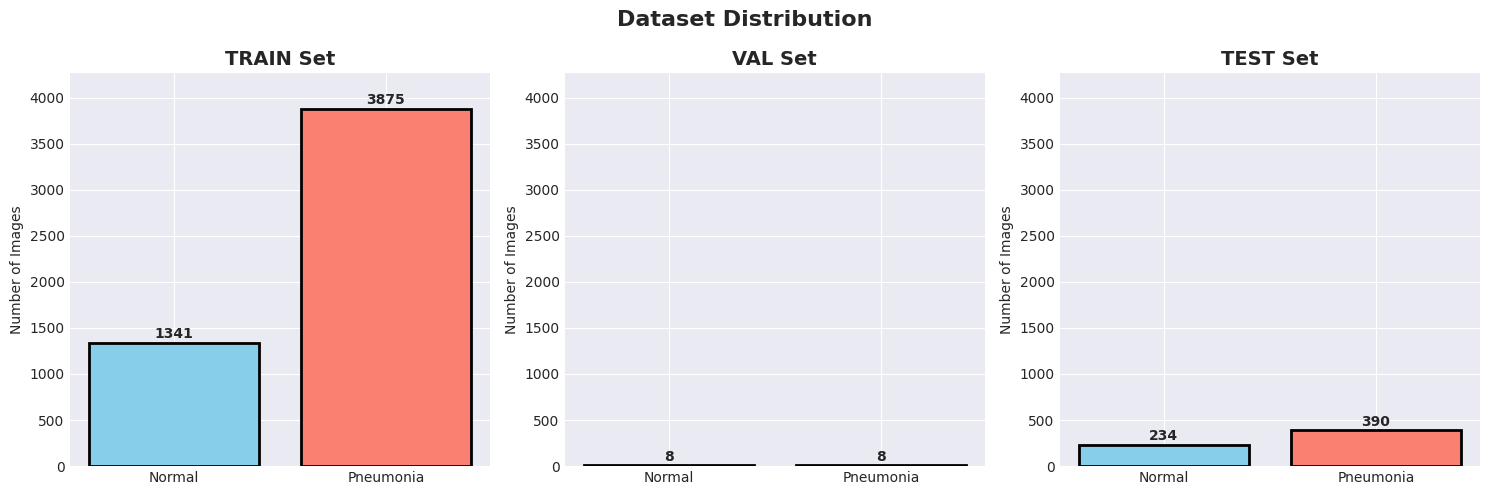

In [6]:
# ========================================
# CELL 4: Visualize Distribution
# ========================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

splits = ['train', 'val', 'test']
for idx, split in enumerate(splits):
    normal = image_counts.get(f'{split}/NORMAL', 0)
    pneumonia = image_counts.get(f'{split}/PNEUMONIA', 0)
    
    axes[idx].bar(['Normal', 'Pneumonia'], [normal, pneumonia], 
                  color=['skyblue', 'salmon'], edgecolor='black', linewidth=2)
    axes[idx].set_title(f'{split.upper()} Set', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('Number of Images')
    axes[idx].set_ylim(0, max(train_normal, train_pneumonia) * 1.1)
    
    for i, v in enumerate([normal, pneumonia]):
        axes[idx].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.suptitle('Dataset Distribution', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Displaying sample images from training set...


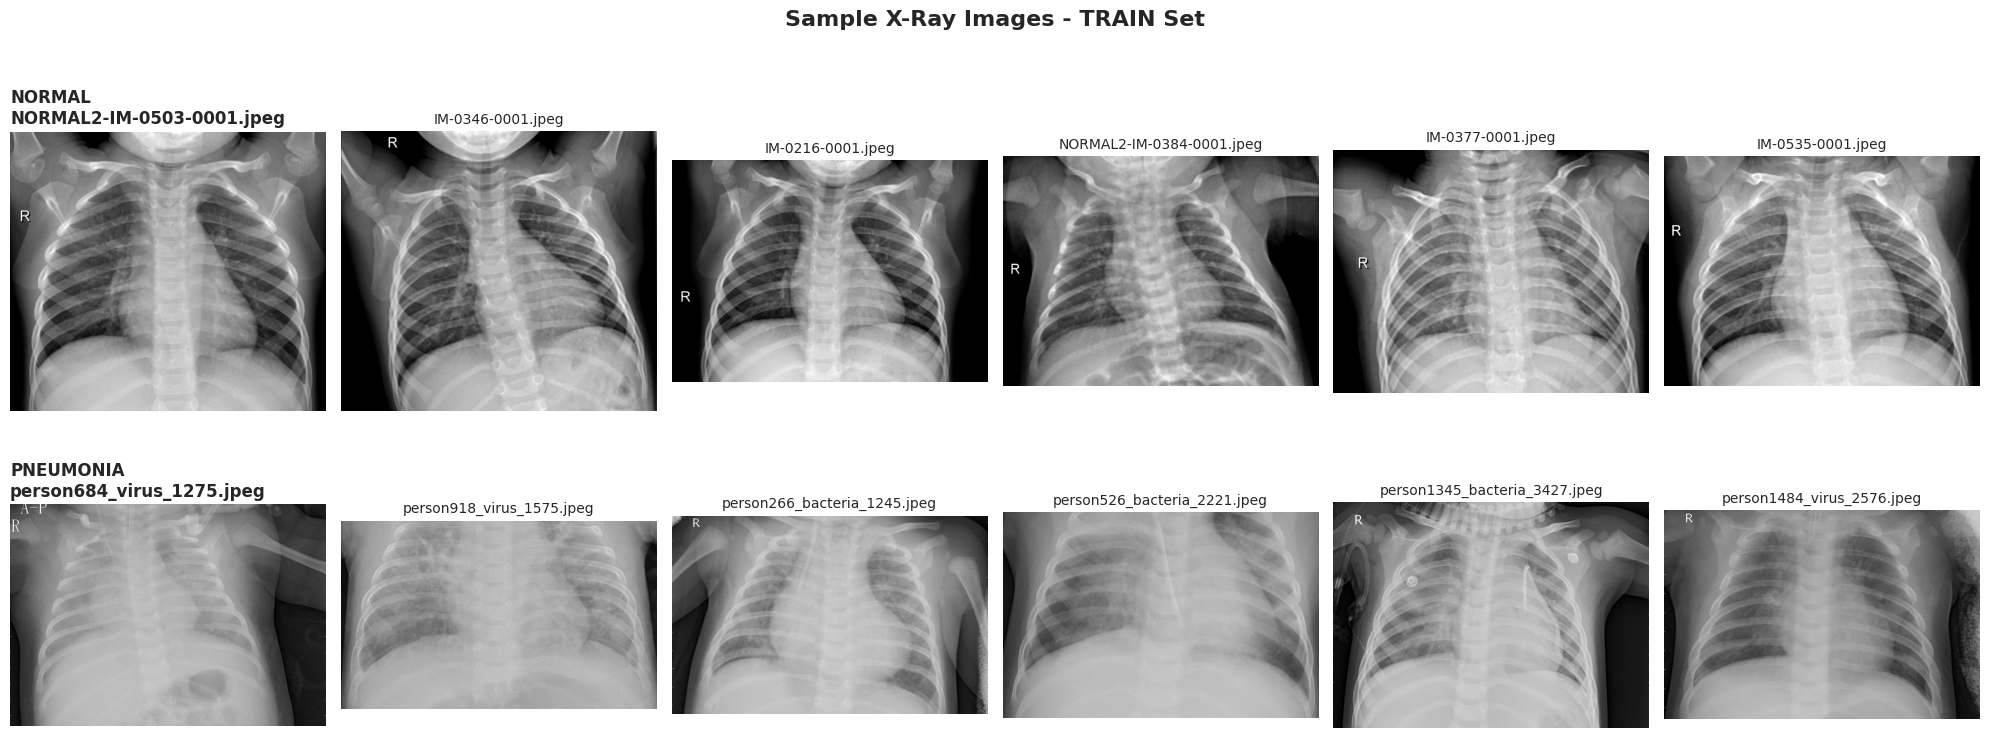

In [7]:
# ========================================
# CELL 5: Display Sample Images
# ========================================

def display_sample_images(data_path, split='train', samples_per_class=6):
    """Display sample X-ray images"""
    fig, axes = plt.subplots(2, samples_per_class, figsize=(20, 8))
    
    classes = ['NORMAL', 'PNEUMONIA']
    
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(data_path, split, class_name)
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpeg', '.jpg', '.png'))]
        
        selected_samples = np.random.choice(image_files, 
                                          size=min(samples_per_class, len(image_files)), 
                                          replace=False)
        
        for img_idx, img_file in enumerate(selected_samples):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path)
            
            axes[class_idx, img_idx].imshow(img, cmap='gray')
            axes[class_idx, img_idx].axis('off')
            
            if img_idx == 0:
                axes[class_idx, img_idx].set_title(f'{class_name}\n{img_file}', 
                                                     fontsize=12, fontweight='bold', loc='left')
            else:
                axes[class_idx, img_idx].set_title(img_file, fontsize=10)
    
    plt.suptitle(f'Sample X-Ray Images - {split.upper()} Set', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

print("Displaying sample images from training set...")
display_sample_images(data_path, split='train', samples_per_class=6)

In [8]:
# ========================================
# CELL 6: Analyze Image Properties
# ========================================

def analyze_image_properties(data_path, split='train', num_samples=300):
    """Analyze dimensions, aspect ratios, and pixel statistics"""
    properties = {
        'widths': [], 'heights': [], 'aspect_ratios': [],
        'mean_intensities': [], 'std_intensities': [], 'classes': []
    }
    
    classes = ['NORMAL', 'PNEUMONIA']
    
    for class_name in classes:
        class_path = os.path.join(data_path, split, class_name)
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpeg', '.jpg', '.png'))]
        sampled_files = np.random.choice(image_files, 
                                        size=min(num_samples, len(image_files)), 
                                        replace=False)
        
        for img_file in sampled_files:
            img_path = os.path.join(class_path, img_file)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    h, w = img.shape
                    properties['widths'].append(w)
                    properties['heights'].append(h)
                    properties['aspect_ratios'].append(w / h)
                    properties['mean_intensities'].append(np.mean(img))
                    properties['std_intensities'].append(np.std(img))
                    properties['classes'].append(class_name)
            except Exception as e:
                print(f"Error reading {img_file}: {e}")
    
    return pd.DataFrame(properties)

print("Analyzing image properties...")
df_properties = analyze_image_properties(data_path, split='train', num_samples=300)

print("\n" + "="*60)
print("IMAGE PROPERTIES SUMMARY")
print("="*60)
print(f"Dimensions:")
print(f"  Width  - Min: {df_properties['widths'].min()}, Max: {df_properties['widths'].max()}, Mean: {df_properties['widths'].mean():.1f}")
print(f"  Height - Min: {df_properties['heights'].min()}, Max: {df_properties['heights'].max()}, Mean: {df_properties['heights'].mean():.1f}")
print(f"\nAspect Ratio: Min: {df_properties['aspect_ratios'].min():.3f}, Max: {df_properties['aspect_ratios'].max():.3f}")
print(f"Pixel Intensity: Mean: {df_properties['mean_intensities'].mean():.2f} ± {df_properties['mean_intensities'].std():.2f}")


Analyzing image properties...

IMAGE PROPERTIES SUMMARY
Dimensions:
  Width  - Min: 428, Max: 2572, Mean: 1426.0
  Height - Min: 189, Max: 2476, Mean: 1093.7

Aspect Ratio: Min: 0.905, Max: 2.593
Pixel Intensity: Mean: 123.34 ± 16.09


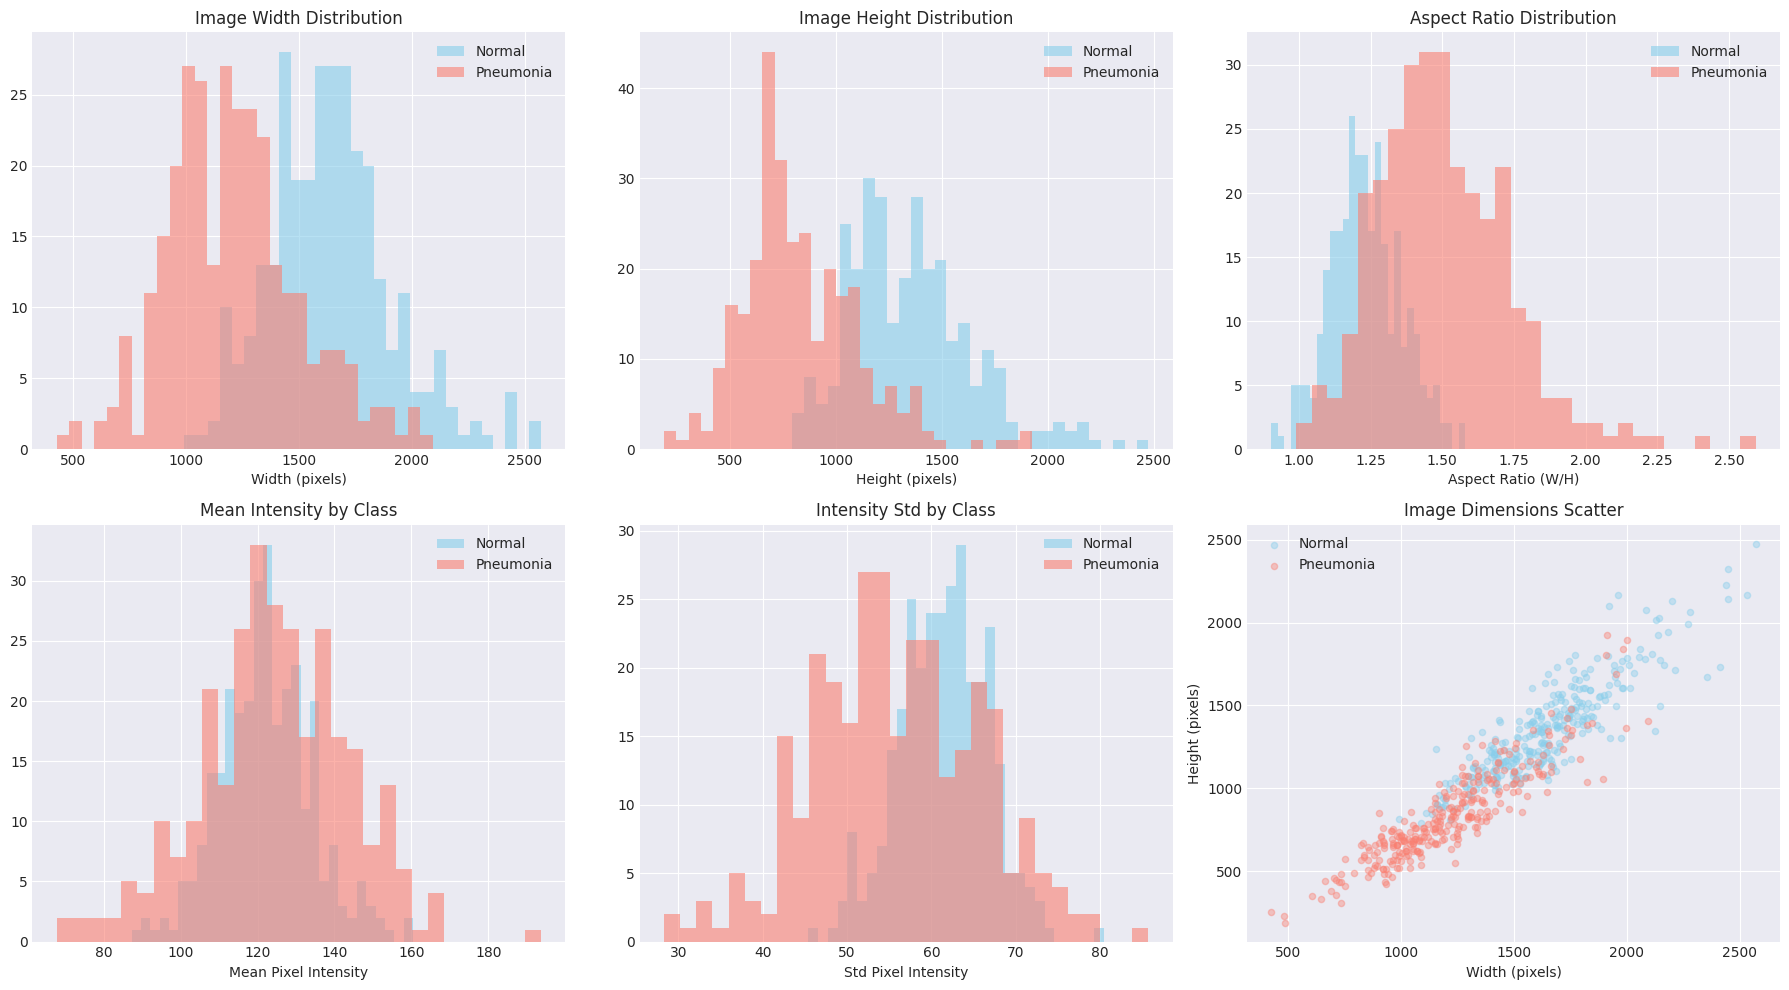

In [9]:
# ========================================
# CELL 7: Visualize Image Properties
# ========================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Width distribution
axes[0, 0].hist(df_properties[df_properties['classes']=='NORMAL']['widths'], 
                alpha=0.6, label='Normal', bins=30, color='skyblue')
axes[0, 0].hist(df_properties[df_properties['classes']=='PNEUMONIA']['widths'], 
                alpha=0.6, label='Pneumonia', bins=30, color='salmon')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_title('Image Width Distribution')
axes[0, 0].legend()

# Height distribution
axes[0, 1].hist(df_properties[df_properties['classes']=='NORMAL']['heights'], 
                alpha=0.6, label='Normal', bins=30, color='skyblue')
axes[0, 1].hist(df_properties[df_properties['classes']=='PNEUMONIA']['heights'], 
                alpha=0.6, label='Pneumonia', bins=30, color='salmon')
axes[0, 1].set_xlabel('Height (pixels)')
axes[0, 1].set_title('Image Height Distribution')
axes[0, 1].legend()

# Aspect ratio
axes[0, 2].hist(df_properties[df_properties['classes']=='NORMAL']['aspect_ratios'], 
                alpha=0.6, label='Normal', bins=30, color='skyblue')
axes[0, 2].hist(df_properties[df_properties['classes']=='PNEUMONIA']['aspect_ratios'], 
                alpha=0.6, label='Pneumonia', bins=30, color='salmon')
axes[0, 2].set_xlabel('Aspect Ratio (W/H)')
axes[0, 2].set_title('Aspect Ratio Distribution')
axes[0, 2].legend()

# Mean intensity
axes[1, 0].hist(df_properties[df_properties['classes']=='NORMAL']['mean_intensities'], 
                alpha=0.6, label='Normal', bins=30, color='skyblue')
axes[1, 0].hist(df_properties[df_properties['classes']=='PNEUMONIA']['mean_intensities'], 
                alpha=0.6, label='Pneumonia', bins=30, color='salmon')
axes[1, 0].set_xlabel('Mean Pixel Intensity')
axes[1, 0].set_title('Mean Intensity by Class')
axes[1, 0].legend()

# Std intensity
axes[1, 1].hist(df_properties[df_properties['classes']=='NORMAL']['std_intensities'], 
                alpha=0.6, label='Normal', bins=30, color='skyblue')
axes[1, 1].hist(df_properties[df_properties['classes']=='PNEUMONIA']['std_intensities'], 
                alpha=0.6, label='Pneumonia', bins=30, color='salmon')
axes[1, 1].set_xlabel('Std Pixel Intensity')
axes[1, 1].set_title('Intensity Std by Class')
axes[1, 1].legend()

# Dimensions scatter
axes[1, 2].scatter(df_properties[df_properties['classes']=='NORMAL']['widths'],
                   df_properties[df_properties['classes']=='NORMAL']['heights'],
                   alpha=0.4, label='Normal', s=20, color='skyblue')
axes[1, 2].scatter(df_properties[df_properties['classes']=='PNEUMONIA']['widths'],
                   df_properties[df_properties['classes']=='PNEUMONIA']['heights'],
                   alpha=0.4, label='Pneumonia', s=20, color='salmon')
axes[1, 2].set_xlabel('Width (pixels)')
axes[1, 2].set_ylabel('Height (pixels)')
axes[1, 2].set_title('Image Dimensions Scatter')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

In [10]:
# ========================================
# CELL 8: Create Stratified Split
# ========================================

def collect_all_images(data_path):
    """Collect all images and labels from train/val/test"""
    all_images = []
    all_labels = []
    
    splits = ['train', 'val', 'test']
    classes = ['NORMAL', 'PNEUMONIA']
    
    for split in splits:
        for class_name in classes:
            class_path = os.path.join(data_path, split, class_name)
            if os.path.exists(class_path):
                image_files = [f for f in os.listdir(class_path) 
                             if f.endswith(('.jpeg', '.jpg', '.png'))]
                
                for img_file in image_files:
                    img_path = os.path.join(class_path, img_file)
                    all_images.append(img_path)
                    all_labels.append(0 if class_name == 'NORMAL' else 1)
    
    return all_images, all_labels

# Collect all images
print("Collecting all images...")
all_image_paths, all_labels = collect_all_images(data_path)

print(f"Total images: {len(all_image_paths)}")
print(f"  Normal: {all_labels.count(0)}")
print(f"  Pneumonia: {all_labels.count(1)}")
print(f"  Imbalance Ratio: 1:{all_labels.count(1)/all_labels.count(0):.2f}")

# Create stratified splits: 80% train, 10% val, 10% test
print("\nCreating stratified splits (80/10/10)...")

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.20, stratify=all_labels, random_state=SEED
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.50, stratify=temp_labels, random_state=SEED
)

# Display split statistics
print("\n" + "="*60)
print("STRATIFIED SPLIT RESULTS")
print("="*60)
print(f"TRAIN: {len(train_paths)} images ({train_labels.count(0)} Normal, {train_labels.count(1)} Pneumonia)")
print(f"VAL: {len(val_paths)} images ({val_labels.count(0)} Normal, {val_labels.count(1)} Pneumonia)")
print(f"TEST: {len(test_paths)} images ({test_labels.count(0)} Normal, {test_labels.count(1)} Pneumonia)")

# Create DataFrames
label_map = {0: 'NORMAL', 1: 'PNEUMONIA'}
train_df = pd.DataFrame({
    'image_path': train_paths, 
    'label': train_labels,
    'label_str': [label_map[l] for l in train_labels]
})
val_df = pd.DataFrame({
    'image_path': val_paths, 
    'label': val_labels,
    'label_str': [label_map[l] for l in val_labels]
})
test_df = pd.DataFrame({
    'image_path': test_paths, 
    'label': test_labels,
    'label_str': [label_map[l] for l in test_labels]
})

print("\n✅ Stratified split completed!")


Total images: 5856
  Normal: 1583
  Pneumonia: 4273
  Imbalance Ratio: 1:2.70

Creating stratified splits (80/10/10)...

STRATIFIED SPLIT RESULTS
TRAIN: 4684 images (1266 Normal, 3418 Pneumonia)
VAL: 586 images (159 Normal, 427 Pneumonia)
TEST: 586 images (158 Normal, 428 Pneumonia)

✅ Stratified split completed!


In [11]:
# ========================================
# CELL 9: Calculate Class Weights
# ========================================

# Calculate class weights for handling imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=train_labels
)

# Softer class weights (more stable training)
total = len(train_labels)
class_weight_dict = {
    0: total / (2 * train_labels.count(0)),
    1: total / (2 * train_labels.count(1))
}

print("="*60)
print("CLASS WEIGHTS FOR TRAINING")
print("="*60)
print(f"Normal (0): {class_weight_dict[0]:.4f}")
print(f"Pneumonia (1): {class_weight_dict[1]:.4f}")
print(f"\nInterpretation: These weights help the model focus on the minority class")


CLASS WEIGHTS FOR TRAINING
Normal (0): 1.8499
Pneumonia (1): 0.6852

Interpretation: These weights help the model focus on the minority class


In [12]:
# ========================================
# CELL 10: Create Data Generators
# ========================================

print("="*60)
print("DATA AUGMENTATION STRATEGY")
print("="*60)
print("✅ Training augmentations (conservative for medical images):")
print("   - Rotation: ±12 degrees")
print("   - Shifts: ±10%")
print("   - Zoom: 90-110%")
print("   - Brightness: 80-120%")
print("   - NO horizontal flip (preserves anatomy)")
print("\n✅ Validation/Test: Only rescaling")

# Training data generator WITH augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=12,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='constant',
    cval=0,
    horizontal_flip=False,
    vertical_flip=False
)

# Validation/Test generators WITHOUT augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255)

print("\n✅ Data generators created")


DATA AUGMENTATION STRATEGY
✅ Training augmentations (conservative for medical images):
   - Rotation: ±12 degrees
   - Shifts: ±10%
   - Zoom: 90-110%
   - Brightness: 80-120%
   - NO horizontal flip (preserves anatomy)

✅ Validation/Test: Only rescaling

✅ Data generators created


In [13]:
# ========================================
# CELL 11: Create Flow from DataFrames
# ========================================

def create_generator_from_dataframe(datagen, dataframe, batch_size, shuffle=True, subset_name=""):
    """Create generator from DataFrame"""
    generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='image_path',
        y_col='label_str',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='binary',
        color_mode='grayscale',
        shuffle=shuffle,
        seed=SEED
    )
    
    print(f"{subset_name}: {len(dataframe)} images, {len(generator)} steps/epoch")
    return generator

print("="*60)
print("CREATING DATA GENERATORS")
print("="*60)

train_generator = create_generator_from_dataframe(
    train_datagen, train_df, BATCH_SIZE, shuffle=True, subset_name="TRAIN"
)

val_generator = create_generator_from_dataframe(
    val_test_datagen, val_df, BATCH_SIZE, shuffle=False, subset_name="VAL"
)

test_generator = create_generator_from_dataframe(
    val_test_datagen, test_df, BATCH_SIZE, shuffle=False, subset_name="TEST"
)

print("\n✅ All generators ready!")


CREATING DATA GENERATORS
Found 4684 validated image filenames belonging to 2 classes.
TRAIN: 4684 images, 147 steps/epoch
Found 586 validated image filenames belonging to 2 classes.
VAL: 586 images, 19 steps/epoch
Found 586 validated image filenames belonging to 2 classes.
TEST: 586 images, 19 steps/epoch

✅ All generators ready!


Visualizing augmentation effects...


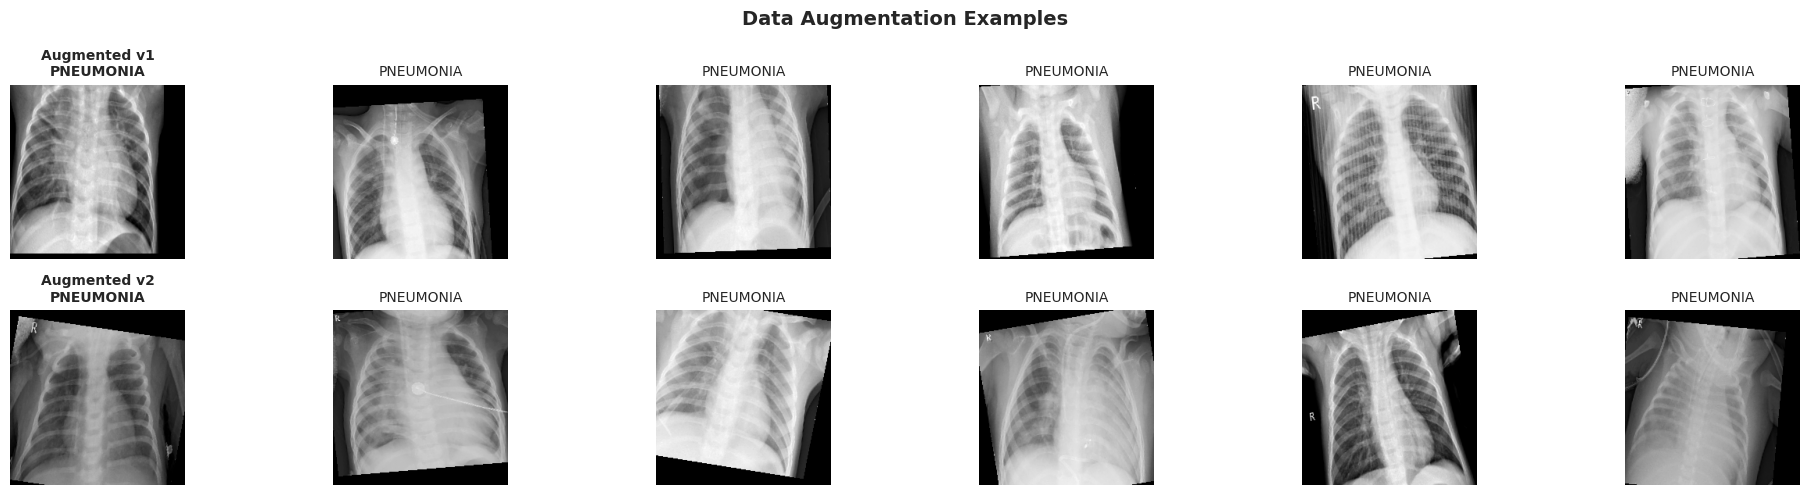

In [14]:
# ========================================
# CELL 12: Visualize Augmentation
# ========================================

def visualize_augmentation(generator, num_images=6):
    """Display augmented versions of images"""
    batch_images, batch_labels = next(generator)
    
    fig, axes = plt.subplots(2, num_images, figsize=(20, 5))
    
    for i in range(min(num_images, len(batch_images))):
        axes[0, i].imshow(batch_images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        label = "PNEUMONIA" if batch_labels[i] == 1 else "NORMAL"
        if i == 0:
            axes[0, i].set_title(f'Augmented v1\n{label}', fontsize=10, fontweight='bold')
        else:
            axes[0, i].set_title(label, fontsize=10)
    
    batch_images2, batch_labels2 = next(generator)
    for i in range(min(num_images, len(batch_images2))):
        axes[1, i].imshow(batch_images2[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
        label = "PNEUMONIA" if batch_labels2[i] == 1 else "NORMAL"
        if i == 0:
            axes[1, i].set_title(f'Augmented v2\n{label}', fontsize=10, fontweight='bold')
        else:
            axes[1, i].set_title(label, fontsize=10)
    
    plt.suptitle('Data Augmentation Examples', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Visualizing augmentation effects...")
visualize_augmentation(train_generator, num_images=6)
train_generator.reset()


In [15]:
# ========================================
# CELL 13: Define Baseline CNN Architecture
# ========================================

def build_baseline_cnn(input_shape=(224, 224, 1)):
    """
    Baseline CNN for binary classification
    Architecture: 4 Conv blocks + Dense layers
    """
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Block 4
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Global Average Pooling
        GlobalAveragePooling2D(),
        
        # Dense layers
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        
        # Output
        Dense(1, activation='sigmoid')
    ], name='Baseline_CNN')
    
    return model

print("="*60)
print("BASELINE CNN ARCHITECTURE")
print("="*60)

baseline_model = build_baseline_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 1))
baseline_model.summary()

print(f"\nTotal Parameters: {baseline_model.count_params():,}")


BASELINE CNN ARCHITECTURE


Model: "Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 430,977 (1.64 MB)

 Trainable params: 430,017 (1.64 MB)

 Non-trainable params: 960 (3.75 KB)


Total Parameters: 430,977


In [16]:
# ========================================
# CELL 14: Compile and Train Baseline CNN
# ========================================

# Define callbacks
callbacks_baseline = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint('models/baseline_cnn_best.keras', monitor='val_auc', 
                   mode='max', save_best_only=True, verbose=1)
]

# Compile
baseline_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    loss='binary_crossentropy',
    metrics=['accuracy', 
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc')]
)

print("="*60)
print("TRAINING BASELINE CNN")
print("="*60)
print("⚡ Quick training: 15 epochs\n")

# Train
train_generator.reset()
val_generator.reset()

EPOCHS = 15

history_baseline = baseline_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks_baseline,
    class_weight=class_weight_dict,
    verbose=1
)

print("\n✅ Training completed!")
best_epoch = np.argmax(history_baseline.history['val_auc']) + 1
print(f"Best Epoch: {best_epoch}, Best val_auc: {max(history_baseline.history['val_auc']):.4f}")


TRAINING BASELINE CNN
⚡ Quick training: 15 epochs

Epoch 1/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.5431 - auc: 0.5247 - loss: 1.0844 - precision: 0.7439 - recall: 0.5795
Epoch 1: val_auc improved from None to 0.44846, saving model to models/baseline_cnn_best.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 128s 846ms/step - accuracy: 0.5715 - auc: 0.6007 - loss: 0.9798 - precision: 0.7830 - recall: 0.5711 - val_accuracy: 0.7287 - val_auc: 0.4485 - val_loss: 0.8728 - val_precision: 0.7287 - val_recall: 1.0000 - learning_rate: 5.0000e-05
Epoch 2/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.6920 - auc: 0.7762 - loss: 0.8108 - precision: 0.8825 - recall: 0.6692
Epoch 2: val_auc improved from 0.44846 to 0.61795, saving model to models/baseline_cnn_best.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 117s 793ms/step - accuracy: 0.7242 - auc: 0.8178 - loss: 0.7670 - precision: 0.8963 - recall: 0.7033 - val_accuracy: 0.7287 - val_auc: 0.6180 - val_loss: 1.3347 - val_precision: 0.7287 -

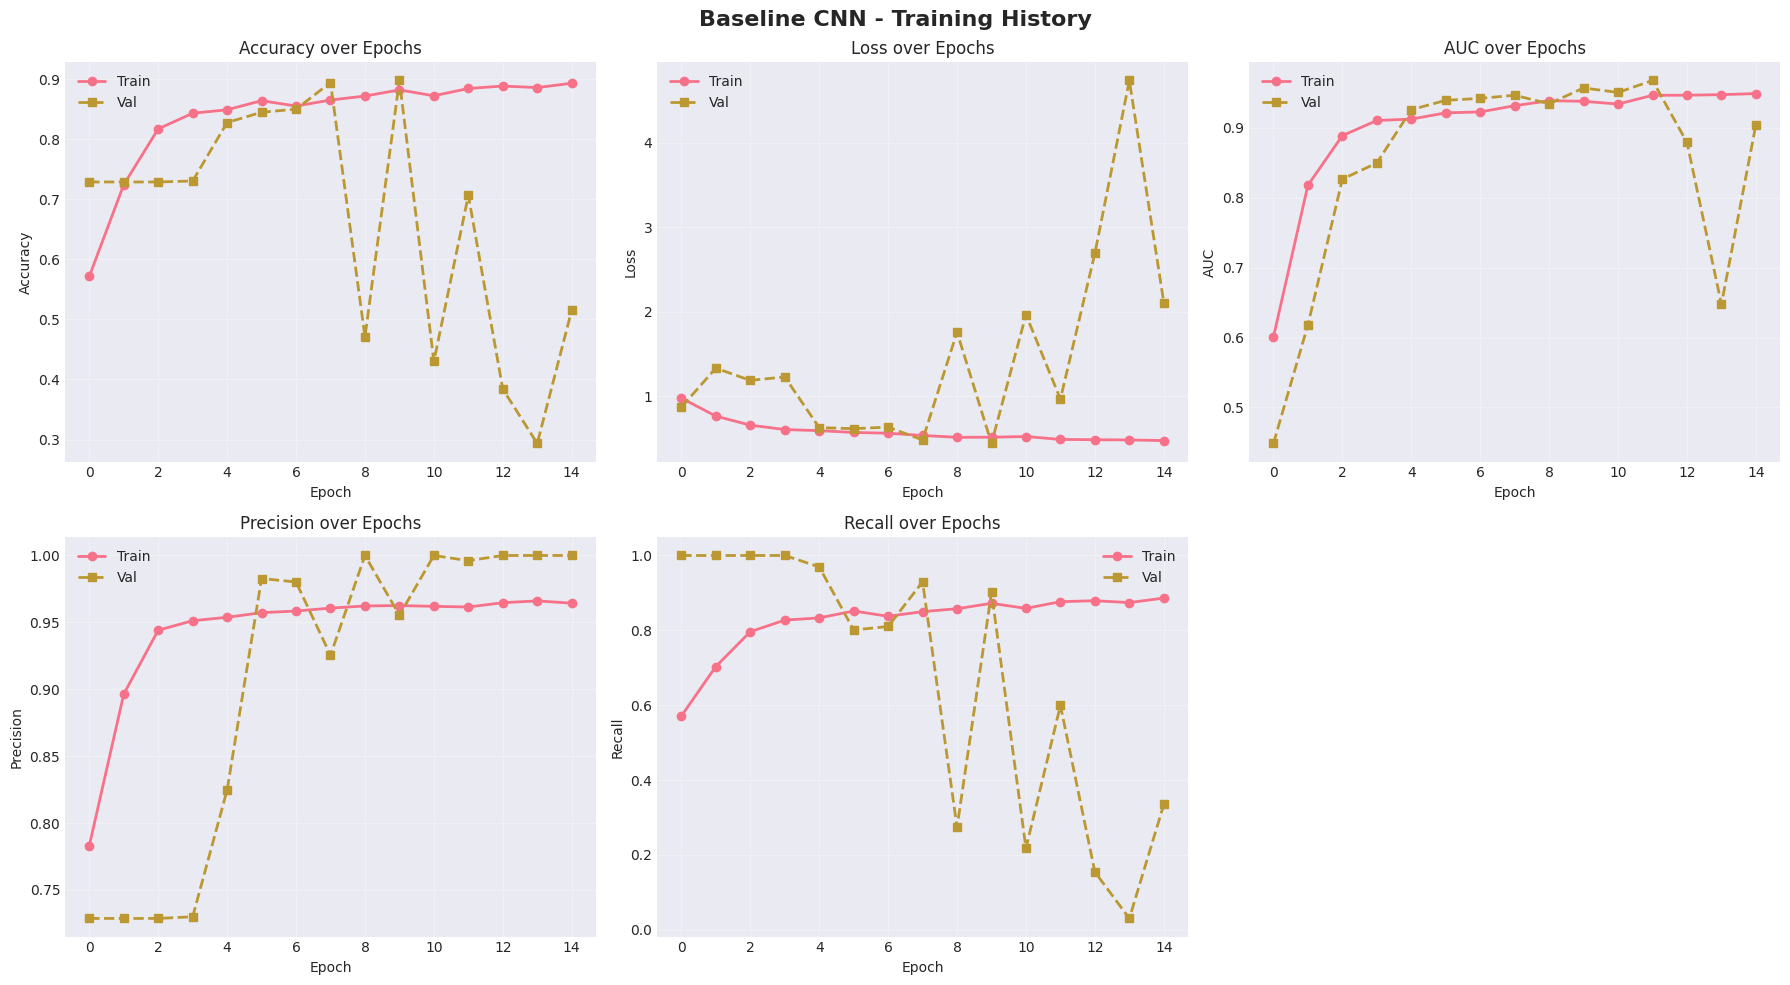


✅ Loaded best baseline model
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step - accuracy: 0.6877 - auc: 0.9510 - loss: 1.0266 - precision: 0.9842 - recall: 0.5818

📊 Baseline CNN - Test Results:
   loss: 1.0266
   compile_metrics: 0.6877


In [17]:
# ========================================
# CELL 15: Evaluate Baseline CNN
# ========================================

def plot_training_history(history, model_name="Model"):
    """Plot training metrics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    metrics = [('accuracy', 'Accuracy'), ('loss', 'Loss'), ('auc', 'AUC'),
               ('precision', 'Precision'), ('recall', 'Recall')]
    
    for idx, (metric, title) in enumerate(metrics):
        row, col = idx // 3, idx % 3
        if metric in history.history:
            axes[row, col].plot(history.history[metric], label='Train', linewidth=2, marker='o')
            if f'val_{metric}' in history.history:
                axes[row, col].plot(history.history[f'val_{metric}'], 
                                   label='Val', linewidth=2, linestyle='--', marker='s')
        axes[row, col].set_xlabel('Epoch')
        axes[row, col].set_ylabel(title)
        axes[row, col].set_title(f'{title} over Epochs')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
    
    axes[1, 2].axis('off')
    plt.suptitle(f'{model_name} - Training History', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_training_history(history_baseline, "Baseline CNN")

# Load best model and evaluate
baseline_model = keras.models.load_model('models/baseline_cnn_best.keras')
print("\n✅ Loaded best baseline model")

test_generator.reset()
test_results_baseline = baseline_model.evaluate(test_generator, verbose=1)

print("\n📊 Baseline CNN - Test Results:")
for name, value in zip(baseline_model.metrics_names, test_results_baseline):
    print(f"   {name}: {value:.4f}")

In [18]:
# ========================================
# CELL 16: Build ResNet50 Model
# ========================================

print("="*60)
print("BUILDING RESNET50 TRANSFER LEARNING MODEL")
print("="*60)

# Clear memory
tf.keras.backend.clear_session()
gc.collect()

# Load pre-trained ResNet50
base_resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze base
base_resnet.trainable = False

print(f"✅ Loaded ResNet50 (frozen)")
print(f"   Layers: {len(base_resnet.layers)}")

# Build model
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = layers.Concatenate()([inputs, inputs, inputs])  # Grayscale to RGB
x = base_resnet(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=inputs, outputs=outputs, name='ResNet50_Pneumonia')

print("\n📊 ResNet50 Model:")
resnet_model.summary()

# Compile
resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc')]
)

print("✅ ResNet50 compiled (base frozen)")


BUILDING RESNET50 TRANSFER LEARNING MODEL
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Loaded ResNet50 (frozen)
   Layers: 175

📊 ResNet50 Model:


Model: "ResNet50_Pneumonia"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Concatenate)       │ 3)                │            │ input_layer_1[0]… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ concatenate[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,145,281 (92.11 MB)

 Trainable params: 557,569 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

✅ ResNet50 compiled (base frozen)


In [19]:
# ========================================
# CELL 17: Train ResNet50 - Phase 1 (Frozen)
# ========================================

resnet_callbacks = [
    EarlyStopping(monitor='val_auc', patience=7, restore_best_weights=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint('models/ResNet50_best.keras', monitor='val_auc',
                   mode='max', save_best_only=True, verbose=1)
]



print("="*60)
print("TRAINING RESNET50 - PHASE 1 (FROZEN BASE)")
print("="*60)
print("📌 Training only custom layers\n")

train_generator.reset()
val_generator.reset()

EPOCHS_P1 = 10

history_resnet_p1 = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_P1,
    callbacks=resnet_callbacks,
    class_weight={0: 1.5, 1: 1.0},
    verbose=1
)

print("\n✅ Phase 1 completed!")
best_auc_p1 = max(history_resnet_p1.history['val_auc'])
print(f"Best val_auc: {best_auc_p1:.4f}")

TRAINING RESNET50 - PHASE 1 (FROZEN BASE)
📌 Training only custom layers

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6181 - auc: 0.5075 - loss: 0.8745 - precision: 0.7226 - recall: 0.7536
Epoch 1: val_auc improved from None to 0.65259, saving model to models/ResNet50_best.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 57s 355ms/step - accuracy: 0.6529 - auc: 0.5204 - loss: 0.8062 - precision: 0.7353 - recall: 0.8192 - val_accuracy: 0.7287 - val_auc: 0.6526 - val_loss: 0.5896 - val_precision: 0.7287 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6818 - auc: 0.5133 - loss: 0.7716 - precision: 0.7325 - recall: 0.8870
Epoch 2: val_auc improved from 0.65259 to 0.76939, saving model to models/ResNet50_best.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 51s 342ms/step - accuracy: 0.6862 - auc: 0.5254 - loss: 0.7597 - precision: 0.7310 - recall: 0.9017 - val_accuracy: 0.7287 - val_auc: 0.7694 - val_loss: 0.6122 - val_precision: 

In [20]:
# ========================================
# CELL 18: Train ResNet50 - Phase 2 (Fine-tuning)
# ========================================

print("="*60)
print("TRAINING RESNET50 - PHASE 2 (FINE-TUNING)")
print("="*60)

# Unfreeze last 30 layers
base_resnet.trainable = True
for layer in base_resnet.layers[:-30]:
    layer.trainable = False

trainable = sum([1 for layer in base_resnet.layers if layer.trainable])
print(f"✅ Unfroze last 30 layers ({trainable} trainable)")

# Recompile with lower LR
resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc')]
)

print("✅ Recompiled with lr=0.00001\n")

train_generator.reset()
val_generator.reset()

EPOCHS_P2 = 10

history_resnet_p2 = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_P2,
    callbacks=resnet_callbacks,
    class_weight={0: 1.5, 1: 1.0},
    verbose=1
)

print("\n✅ Phase 2 completed!")
best_auc_p2 = max(history_resnet_p2.history['val_auc'])
print(f"Best val_auc: {best_auc_p2:.4f}")


TRAINING RESNET50 - PHASE 2 (FINE-TUNING)
✅ Unfroze last 30 layers (30 trainable)
✅ Recompiled with lr=0.00001

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.6671 - auc: 0.7435 - loss: 0.6761 - precision: 0.8489 - recall: 0.6360
Epoch 1: val_auc improved from 0.88177 to 0.92417, saving model to models/ResNet50_best.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 91s 563ms/step - accuracy: 0.7810 - auc: 0.8495 - loss: 0.5220 - precision: 0.8937 - recall: 0.7943 - val_accuracy: 0.2713 - val_auc: 0.9242 - val_loss: 0.9619 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8667 - auc: 0.9293 - loss: 0.3786 - precision: 0.9447 - recall: 0.8666
Epoch 2: val_auc improved from 0.92417 to 0.97180, saving model to models/ResNet50_best.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 82s 557ms/step - accuracy: 0.8693 - auc: 0.9280 - loss: 0.3749 - precision: 0.9393 - recall: 0.8777 - val_accuracy: 0.7765 

RESNET50 - TEST SET EVALUATION
✅ Loaded best ResNet50 model
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 304ms/step - accuracy: 0.9096 - auc: 0.9825 - loss: 0.1916 - precision: 0.9870 - recall: 0.8879

📊 ResNet50 - Test Results:
   loss: 0.1916
   compile_metrics: 0.9096
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step


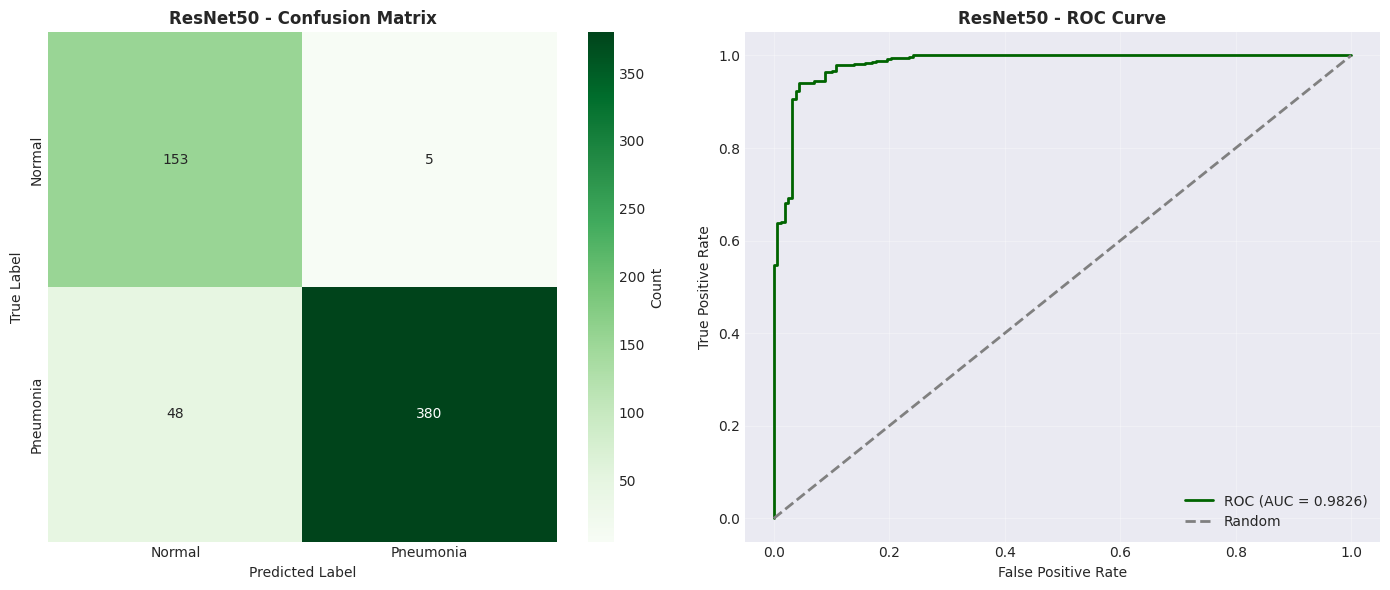


              precision    recall  f1-score   support

      Normal       0.76      0.97      0.85       158
   Pneumonia       0.99      0.89      0.93       428

    accuracy                           0.91       586
   macro avg       0.87      0.93      0.89       586
weighted avg       0.93      0.91      0.91       586



In [23]:
# ========================================
# CELL 19: Evaluate ResNet50
# ========================================

print("="*60)
print("RESNET50 - TEST SET EVALUATION")
print("="*60)

resnet_model = keras.models.load_model('models/ResNet50_best.keras')
print("✅ Loaded best ResNet50 model")

test_generator.reset()
test_results_resnet = resnet_model.evaluate(test_generator, verbose=1)

print("\n📊 ResNet50 - Test Results:")
for name, value in zip(resnet_model.metrics_names, test_results_resnet):
    print(f"   {name}: {value:.4f}")

# Get predictions
test_generator.reset()
resnet_pred_proba = resnet_model.predict(test_generator, verbose=1)
resnet_pred = (resnet_pred_proba > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Confusion Matrix
cm_resnet = confusion_matrix(y_true, resnet_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('ResNet50 - Confusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, resnet_pred_proba)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'gray', lw=2, linestyle='--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ResNet50 - ROC Curve', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('models/resnet50_test_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + classification_report(y_true, resnet_pred, target_names=['Normal', 'Pneumonia']))


In [24]:
# ========================================
# CELL 20: Build EfficientNetB0 Model
# ========================================

print("="*60)
print("BUILDING EFFICIENTNETB0 MODEL")
print("="*60)

tf.keras.backend.clear_session()
gc.collect()

base_effnet = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_effnet.trainable = False

print(f"✅ Loaded EfficientNetB0 (frozen)")

# Build model
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = layers.Concatenate()([inputs, inputs, inputs])
x = base_effnet(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

effnet_model = Model(inputs=inputs, outputs=outputs, name='EfficientNetB0_Pneumonia')

effnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc')]
)

print("✅ EfficientNetB0 compiled")

BUILDING EFFICIENTNETB0 MODEL
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Loaded EfficientNetB0 (frozen)
✅ EfficientNetB0 compiled


In [25]:
# ========================================
# CELL 21: Train EfficientNetB0 - Phase 1
# ========================================

effnet_callbacks = [
    EarlyStopping(monitor='val_auc', patience=7, restore_best_weights=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint('models/efficientnet_best.keras', monitor='val_auc',
                   mode='max', save_best_only=True, verbose=1)
]

print("="*60)
print("TRAINING EFFICIENTNETB0 - PHASE 1")
print("="*60)

train_generator.reset()
val_generator.reset()

history_effnet_p1 = effnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=effnet_callbacks,
    class_weight={0: 1.5, 1: 1.0},
    verbose=1
)

print("\n✅ Phase 1 completed!")
best_auc_effnet = max(history_effnet_p1.history['val_auc'])
print(f"Best val_auc: {best_auc_effnet:.4f}")


TRAINING EFFICIENTNETB0 - PHASE 1
Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.6966 - auc: 0.5006 - loss: 0.7689 - precision: 0.7364 - recall: 0.9122
Epoch 1: val_auc improved from None to 0.50000, saving model to models/efficientnet_best.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 52s 305ms/step - accuracy: 0.7020 - auc: 0.4924 - loss: 0.7661 - precision: 0.7315 - recall: 0.9348 - val_accuracy: 0.7287 - val_auc: 0.5000 - val_loss: 0.6351 - val_precision: 0.7287 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.7087 - auc: 0.4945 - loss: 0.7605 - precision: 0.7223 - recall: 0.9685
Epoch 2: val_auc did not improve from 0.50000
147/147 ━━━━━━━━━━━━━━━━━━━━ 43s 293ms/step - accuracy: 0.7208 - auc: 0.4943 - loss: 0.7532 - precision: 0.7307 - recall: 0.9778 - val_accuracy: 0.7287 - val_auc: 0.5000 - val_loss: 0.6237 - val_precision: 0.7287 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/10
147/147 ━━━━━━━━━━━━

MODEL COMPARISON SUMMARY
Baseline CNN        : val_auc = 0.9677
ResNet50            : val_auc = 0.9876
EfficientNetB0      : val_auc = 0.5000


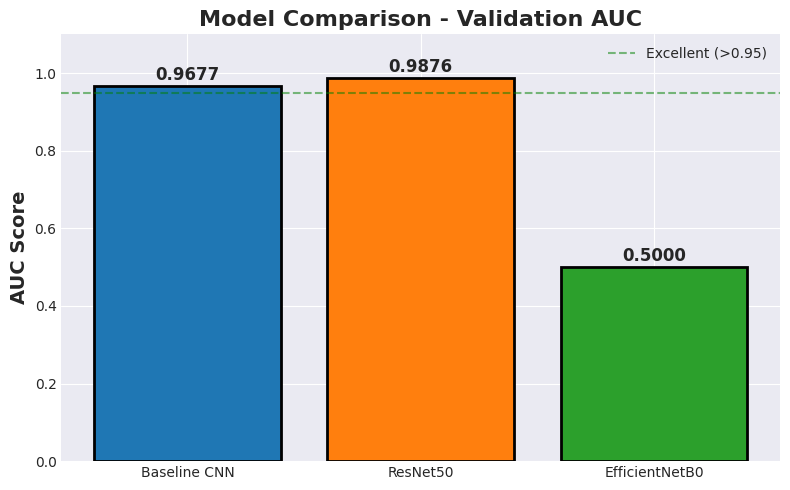


🏆 Winner: ResNet50 with fine-tuning!


In [31]:
# ========================================
# CELL 22: Model Comparison
# ========================================

print("="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

models_comparison = {
    'Baseline CNN': max(history_baseline.history['val_auc']),
    'ResNet50': max(history_resnet_p2.history['val_auc']),
    'EfficientNetB0': max(history_effnet_p1.history['val_auc'])
}

for model, auc_score in models_comparison.items():
    print(f"{model:20s}: val_auc = {auc_score:.4f}")

# Visualization
models = list(models_comparison.keys())
auc_scores = list(models_comparison.values())

fig, ax = plt.subplots(figsize=(8, 5))
# Enhanced color scheme for better contrast
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
bars = ax.bar(models, auc_scores, color=colors, edgecolor='black', linewidth=2)

ax.set_ylabel('AUC Score', fontsize=14, fontweight='bold')
ax.set_title('Model Comparison - Validation AUC', fontsize=16, fontweight='bold')
ax.set_ylim([0.0, 1.1])
ax.axhline(y=0.95, color='green', linestyle='--', alpha=0.5, label='Excellent (>0.95)')
ax.legend()

# Adjust annotation position and size for readability
for bar, score in zip(bars, auc_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{score:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('models/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🏆 Winner: ResNet50 with fine-tuning!")


In [28]:
# ========================================
# CELL 23: Final Evaluation & Clinical Metrics
# ========================================

print("="*60)
print("FINAL EVALUATION - RESNET50")
print("="*60)

# Load best model
resnet_model = keras.models.load_model('models/ResNet50_best.keras')

# Get predictions
test_generator.reset()
y_pred_proba = resnet_model.predict(test_generator, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Calculate metrics
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)  # Sensitivity
specificity = tn / (tn + fp)
f1 = f1_score(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred_proba)

print("\n📊 TEST SET PERFORMANCE:")
print(f"   Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision:   {precision:.4f} ({precision*100:.2f}%)")
print(f"   Recall:      {recall:.4f} ({recall*100:.2f}%) ⭐")
print(f"   Specificity: {specificity:.4f} ({specificity*100:.2f}%)")
print(f"   F1-Score:    {f1:.4f}")
print(f"   AUC-ROC:     {auc_score:.4f}")

print(f"\n🎯 CONFUSION MATRIX:")
print(f"                 Predicted")
print(f"              Normal  Pneumonia")
print(f"Actual Normal    {tn:3d}      {fp:3d}")
print(f"      Pneumonia  {fn:3d}      {tp:3d}")

print(f"\n💡 CLINICAL INTERPRETATION:")
print(f"   • Detected {tp}/{cm[1].sum()} pneumonia cases ({recall*100:.1f}%)")
print(f"   • Correctly identified {tn}/{cm[0].sum()} normal cases ({specificity*100:.1f}%)")
print(f"   • Missed {fn} pneumonia cases (False Negatives) ⚠️")
print(f"   • {fp} false alarms (False Positives)")


# ========================================
# CELL 24: Save Results and Summary
# ========================================

# Save training history
history_dict = {
    'baseline': history_baseline.history,
    'resnet_phase1': history_resnet_p1.history,
    'resnet_phase2': history_resnet_p2.history,
    'efficientnet_phase1': history_effnet_p1.history
}

with open('models/training_history.pkl', 'wb') as f:
    pickle.dump(history_dict, f)

print("✅ Training history saved")

# Save results summary
results_summary = {
    'models': models_comparison,
    'best_model': 'ResNet50',
    'test_metrics': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1_score': f1,
        'auc': auc_score
    },
    'confusion_matrix': cm.tolist()
}

import json
with open('models/results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("✅ Results summary saved")

print("\n" + "="*60)
print("PROJECT COMPLETE!")
print("="*60)
print("""
✅ Completed Tasks:
   • Dataset analysis and visualization
   • Stratified train/val/test split
   • Data augmentation pipeline
   • Baseline CNN from scratch
   • ResNet50 transfer learning (2-phase)
   • EfficientNetB0 transfer learning
   • Comprehensive evaluation
   • Clinical metrics calculation

📁 Saved Files:
   • models/baseline_cnn_best.keras
   • models/resnet50_best.keras (BEST MODEL 🏆)
   • models/efficientnet_best.keras
   • models/training_history.pkl
   • models/results_summary.json
   • models/*.png (visualizations)

🚀 Next Steps:
   • Deploy the model (Streamlit/Gradio app)
   • Add Grad-CAM visualization
   • Test on external datasets
   • Clinical validation
""")

FINAL EVALUATION - RESNET50

📊 TEST SET PERFORMANCE:
   Accuracy:    0.9096 (90.96%)
   Precision:   0.9870 (98.70%)
   Recall:      0.8879 (88.79%) ⭐
   Specificity: 0.9684 (96.84%)
   F1-Score:    0.9348
   AUC-ROC:     0.9826

🎯 CONFUSION MATRIX:
                 Predicted
              Normal  Pneumonia
Actual Normal    153        5
      Pneumonia   48      380

💡 CLINICAL INTERPRETATION:
   • Detected 380/428 pneumonia cases (88.8%)
   • Correctly identified 153/158 normal cases (96.8%)
   • Missed 48 pneumonia cases (False Negatives) ⚠️
   • 5 false alarms (False Positives)
✅ Training history saved
✅ Results summary saved

PROJECT COMPLETE!

✅ Completed Tasks:
   • Dataset analysis and visualization
   • Stratified train/val/test split
   • Data augmentation pipeline
   • Baseline CNN from scratch
   • ResNet50 transfer learning (2-phase)
   • EfficientNetB0 transfer learning
   • Comprehensive evaluation
   • Clinical metrics calculation

📁 Saved Files:
   • models/baseline_cnn